In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torch.utils.data import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import os
import gc

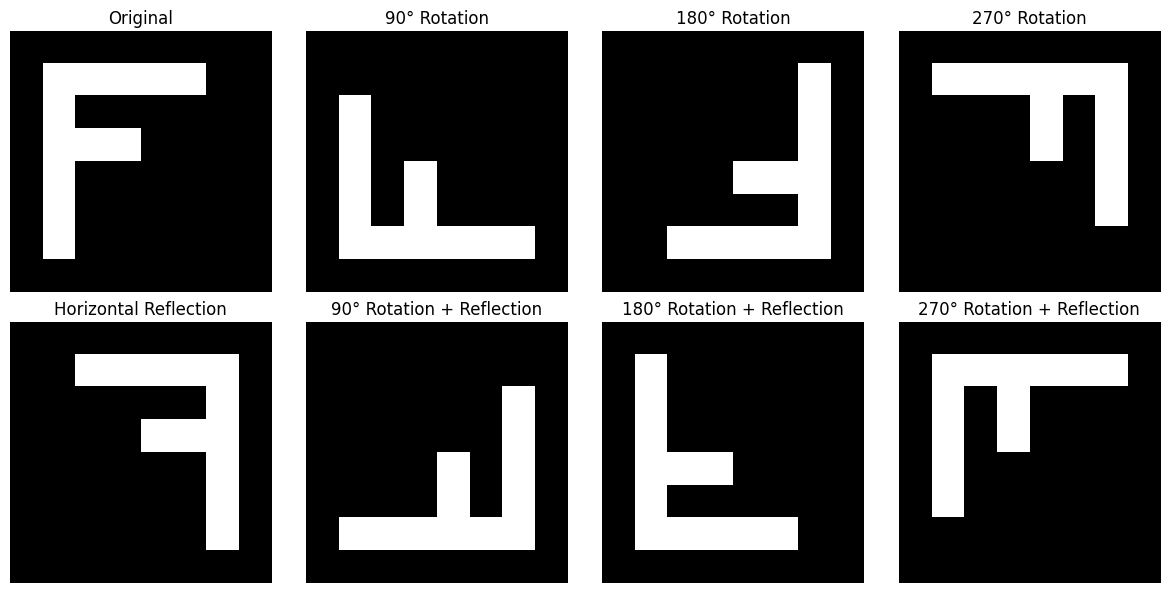

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create an image of the letter "F"
def create_letter_f():
    # Create a blank canvas
    img = np.zeros((8, 8), dtype=np.uint8)
    
    # Draw the letter "F"
    img[1:7, 1] = 1  # Vertical line
    img[1, 1:6] = 1  # Top horizontal line
    img[3, 1:4] = 1  # Middle horizontal line

    return img

# Step 2: Define transformations
def rotate_90(img):
    return np.rot90(img,k=1)  # Rotate 90 degrees clockwise

def reflect_horizontal(img):
    return np.fliplr(img)  # Flip horizontally

# Step 3: Visualize the original and transformed images
def visualize_transformations():
    # Create the original image of "F"
    original_img = create_letter_f()
    
    # Transformations
    tr=[original_img]
    for i in range(1,4):
        tr.append(rotate_90(tr[i-1]))
    for i in range(4):
        tr.append(reflect_horizontal(tr[i%4]))
    
    transformations = [
        ("Original", tr[0]),
        ("90° Rotation", tr[1]),
        ("180° Rotation", tr[2]),
        ("270° Rotation", tr[3]),
        ("Horizontal Reflection", tr[4]),
        ("90° Rotation + Reflection", tr[5]),
        ("180° Rotation + Reflection", tr[6]),
        ("270° Rotation + Reflection", tr[7]),
    ]
    
    # Plot the transformations
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for ax, (title, img) in zip(axes.flatten(), transformations):
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_transformations()

In [2]:
os.environ['TORCH_LOGS'] = "+dynamo"
os.environ['TORCHDYNAMO_VERBOSE'] = "1"

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # Output: (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1), # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        self.fc_mu = nn.Linear(4 * 4 * 512, latent_dim)
        self.fc_logvar = nn.Linear(4 * 4 * 512, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 4 * 4 * 512)

        # Decoder using ConvTranspose2d for upsampling
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            
            # Reshape from latent vector to feature map
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Output: (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # Output: (16, 128, 128)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            
            # Final layer: project to 3 channels (RGB) with 3x3 convolution
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  # Output: (3, 128, 128)
            nn.Tanh()  # Or Sigmoid depending on normalization
            # Final layer outputs RGB values between -1 and 1
        )

    
    def encode(self,x:torch.Tensor):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decode(self,z:torch.Tensor):
        # Decode
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)  # Reshape to image feature map
        x = self.decoder(x)
        return x
    
    def vae_loss(self, recon_x:torch.Tensor, x:torch.Tensor, mu:torch.Tensor, logvar:torch.Tensor):
        # Reconstruction loss (MSE or L1 loss)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        
        # KL Divergence loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return recon_loss + kld_loss

    def forward(self, x:torch.Tensor):
        # Encode
        mu, logvar =self.encode(x)

        # Reparameterize
        std = torch.exp(0.5 * logvar)
        n = torch.randn_like(std)
        z= mu + n * std
        
        # Decode
        x=self.decode(z)
        return x, mu, logvar



In [4]:
# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
# Model, optimizer, and compilation
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim)
compiled_vae = torch.compile(vae,backend="aot_eager").to(device)
optimizer = optim.Adam(compiled_vae.parameters(), lr=0.001)
device

device(type='cpu')

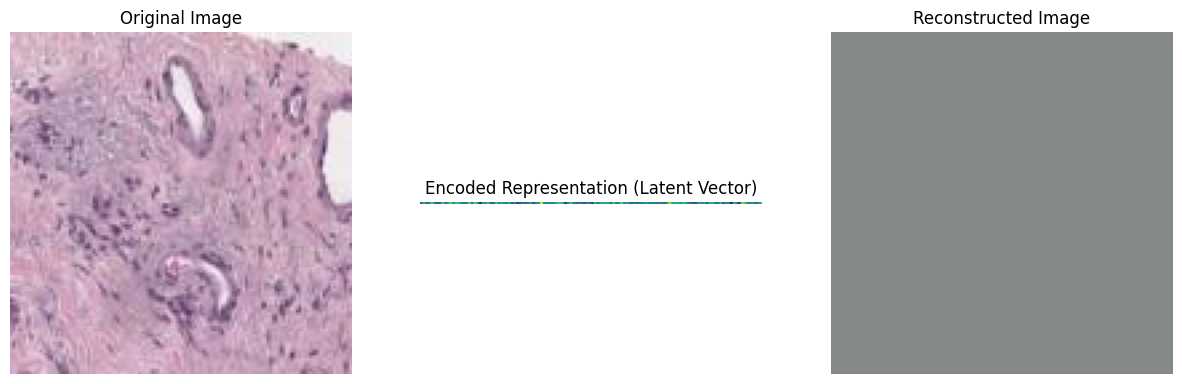

In [8]:
# Load and transform the image
image_path = '../0/4/row_0__col_153.jpg'
image = Image.open(image_path)  # Ensure image is in RGB format

# Define transformation to normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Forward pass through the model
compiled_vae.eval()  # Set model to evaluation mode
with torch.no_grad():
    mu, logvar = compiled_vae.encode(image_tensor)
    z = compiled_vae.reparameterize(mu,logvar)
    reconstructed_image=compiled_vae.decode(z)

# Convert tensors back to images for visualization
def tensor_to_image(tensor):
    # Convert from normalized tensor [-1, 1] to [0, 1] for visualization
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = (tensor + 1) / 2  # Scale to [0, 1]
    tensor = tensor.clamp(0, 1)  # Clamp to ensure values are in range
    return tensor.permute(1, 2, 0).numpy()  # Change to HWC format

# Plot the original, encoded (as a latent vector), and reconstructed images
original_image = tensor_to_image(transform(image).unsqueeze(0))  # Transform and normalize original image
encoded_image = mu.numpy()  # Latent vector (mean)
reconstructed_image = tensor_to_image(reconstructed_image)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(encoded_image.reshape(1, -1))  # Reshape for visualization (1 row, num features)
axes[1].set_title('Encoded Representation (Latent Vector)')
axes[1].axis('off')

axes[2].imshow(reconstructed_image)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.show()

In [5]:
class TiledImageDataset(Dataset):
    def __init__(self, data_dir, image_ids, transform=None):
        self.data_dir = data_dir
        self.image_ids = image_ids
        self.transform = transform
        self.image_paths = []
        
        # Collect all image paths for the given image IDs
        for image_id in image_ids:
            image_folder = os.path.join(data_dir, image_id)
            for img_name in os.listdir(image_folder):
                self.image_paths.append(os.path.join(image_folder, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img


In [7]:
# Assuming `image_ids` is a list of all folder names (IDs of the original images)
data_dir = '../1'
image_ids = os.listdir(data_dir)  # List of all original image IDs

# Split image IDs
train_ids, temp_ids = train_test_split(image_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=2/3, random_state=42)  # 10% validation, 20% test

# Create datasets
train_dataset = TiledImageDataset(data_dir, train_ids, transform=transform)
val_dataset = TiledImageDataset(data_dir, val_ids, transform=transform)
test_dataset = TiledImageDataset(data_dir, test_ids, transform=transform)

batch_size=5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
len(train_dataset)

229040

In [8]:
# Get 10% of training data for each epoch
def get_subset_sampler(dataset, percentage=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split = int(np.ceil(percentage * dataset_size))
    train_indices = indices[:split]
    
    return SubsetRandomSampler(train_indices)

In [ ]:
# Model, optimizer, and compilation
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim)
compiled_vae = torch.compile(vae).to(device)
optimizer = optim.Adam(compiled_vae.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

# Select and save 24 images from the test set (ensure to keep this consistent across epochs)
n=24
fixed_batch = next(iter(DataLoader(test_dataset, batch_size=n, shuffle=False)))
for i in range(n):
    save_image(fixed_batch[i],fp=f'epochs/img_{i}.png')

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/vae_experiment')
# Log original images to TensorBoard
writer.add_images('Original Images', fixed_batch, 0)

# sample 10% of data per epoch and log everything
for epoch in range(num_epochs):
    sampler = get_subset_sampler(train_dataset, percentage=0.1)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    accumulated_gradients = {name: torch.zeros_like(param) for name, param in compiled_vae.named_parameters()}
    compiled_vae.train()
    train_loss = 0
    num_samples=0
    # Use tqdm to create a progress bar for the training loop
    with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch', position=0, leave=False) as pbar:
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = compiled_vae(batch)
            loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            for name, param in compiled_vae.named_parameters():
                if param.grad is not None:
                    accumulated_gradients[name] += param.grad.detach().clone()

            num_samples+=batch.size()[0]

            # Update the progress bar
            pbar.update(1)  # Increment the progress bar by 1
            pbar.set_postfix({'train_loss': loss.item()})  # Display current loss


    train_loss /= num_samples
    train_losses.append(train_loss)


    # Validation loop
    compiled_vae.eval()
    val_loss = 0
    num_samples=0
    with torch.no_grad():
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch + 1}/{num_epochs}', unit='batch',position=1, leave=False) as pbar:
            for batch in val_loader:
                batch = batch.to(device)
                recon_batch, mu, logvar = compiled_vae(batch)
                loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
                val_loss += loss.item()
                num_samples+=batch.size()[0]

                # Update the progress bar
                pbar.update(1)  # Increment the progress bar by 1
                pbar.set_postfix({'val_loss': loss.item()})  # Display current loss

    val_loss /= num_samples
    val_losses.append(val_loss)

    # Save model weights
    current_dir=f'epochs/epoch_{epoch +1}/'
    os.makedirs(current_dir, exist_ok=True)
    torch.save(compiled_vae.state_dict(), os.path.join(current_dir,f'vae_weights_epoch_{epoch + 1}.pth'))

    # At the end of each epoch, save the reconstructions
    compiled_vae.eval()
    with torch.no_grad():
        fixed_batch_epoch = fixed_batch.to(device)
        recon_batch, _, _ = compiled_vae(fixed_batch_epoch)
        recon_batch=recon_batch.cpu()

        # Reverse normalization
        recon_batch = (recon_batch*0.5)+0.5 
        # Clamp the values to be in the range [0, 1]
        recon_batch = torch.clamp(recon_batch, 0, 1)
        for i in range(n):
            save_image(recon_batch[i],fp=os.path.join(current_dir,f'img_recon_{i}.png'))
    
    # Log reconstructed images to TensorBoard
    writer.add_images('Reconstructed Images', recon_batch, epoch)

    # Log the model parameters and accumulated gradients to TensorBoard after the epoch
    for name, param in compiled_vae.named_parameters():
        writer.add_histogram(f'Weights/{name}', param, global_step=epoch)
        if param.grad is not None:
            # Log averaged gradients
            avg_gradient = accumulated_gradients[name] / num_samples
            writer.add_histogram(f'Gradients/{name}', avg_gradient, global_step=epoch)

    # Log training and validation losses
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)

    tqdm.write(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


# After training loop

# Calculate test loss
compiled_vae.eval()
test_loss = 0
num_samples = 0
test_loader = DataLoader(val_dataset, batch_size=batch_size)
with tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            recon_batch, mu, logvar = compiled_vae(batch)
            loss = compiled_vae.vae_loss(recon_batch, batch, mu, logvar)
            test_loss += loss.item()
            num_samples += batch.size()[0]

            # Update the progress bar
            pbar.update(1)  # Increment the progress bar by 1
            pbar.set_postfix({'val_loss': loss.item()})  # Display current loss
test_loss /= num_samples

# Log test losses
writer.add_scalar('Loss/Test', test_loss, 0)

# Close the TensorBoard writer
writer.close()

# Print test loss
tqdm.write(f'Test Loss: {test_loss:.4f}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as an image file
plt.show()  # Display the plot

torch.cuda.empty_cache()
gc.collect()

Training Epoch 1/3:   0%|          | 0/46 [00:00<?, ?batch/s]

BackendCompilerFailed: backend='inductor' raised:
CppCompileError: C++ compile error

Command:
g++ /tmp/torchinductor_maxi/xe/cxegdglpydrc5gu77io5kzasy476m4pcocpph4pjpimakp4hedtz.cpp -shared -fPIC -Wall -std=c++17 -Wno-unused-variable -Wno-unknown-pragmas -D_GLIBCXX_USE_CXX11_ABI=0 -I/home/maxi/Documents/Tesis/Dataset UBC OCEAN/tests/venv/lib/python3.10/site-packages/torch/include -I/home/maxi/Documents/Tesis/Dataset UBC OCEAN/tests/venv/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -I/home/maxi/Documents/Tesis/Dataset UBC OCEAN/tests/venv/lib/python3.10/site-packages/torch/include/TH -I/home/maxi/Documents/Tesis/Dataset UBC OCEAN/tests/venv/lib/python3.10/site-packages/torch/include/THC -I/usr/include/python3.10 -L/home/maxi/Documents/Tesis/Dataset UBC OCEAN/tests/venv/lib/python3.10/site-packages/torch/lib -lgomp -lc10 -O3 -DNDEBUG -ffast-math -fno-finite-math-only -fno-unsafe-math-optimizations -ffp-contract=off -march=native -fopenmp -D TORCH_INDUCTOR_CPP_WRAPPER -D C10_USING_CUSTOM_GENERATED_MACROS -o /tmp/torchinductor_maxi/xe/cxegdglpydrc5gu77io5kzasy476m4pcocpph4pjpimakp4hedtz.so

Output:
In file included from /tmp/torchinductor_maxi/xe/cxegdglpydrc5gu77io5kzasy476m4pcocpph4pjpimakp4hedtz.cpp:2:
/tmp/torchinductor_maxi/sk/cskh5dx62fglpphcrl6723dnmowdabouerrzy3dmqcngbxwfa7bv.h:17:10: fatal error: ATen/NumericUtils.h: No such file or directory
   17 | #include <ATen/NumericUtils.h>
      |          ^~~~~~~~~~~~~~~~~~~~~
compilation terminated.


Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
